# Assignment 5

Your task is to write code for sampling from your encounter model and running a simulation that captures the physical dynamics of the aircraft.
You will then use your code to run a Monte Carlo analysis of the safety of aircraft.

We will have a class competition to see whose model best represents aircraft encounters.
We will measure how close the histogram over encounter miss distances both with and without TCAS (Traffic Alert and Collision Avoidance System) is to the true distribution, and how close the estimated NMAC rate is to the true value.

* distance in each case will be measures using the Kullbeck-Leibler divergence
* TCAS and non-TCAS are evenly weighted
* distance from collision rate is measured by the factor difference magnitude - ie, 5 and 20 are both factors of 2 from 10.

### **What is Turned In:**
Edit the contents of this notebook and turn in our final Julia notebook file (.ipynb), and any associated code files you wrote to Canvas. Do not use any external code or Julia packages other than those used in the class materials.

### Set Up

In [1]:
using BayesNets, Random, BSON, Discretizers, AA120Q, LightGraphs

In [2]:
Random.seed!(1) # set random seed for consistent results

MersenneTwister(UInt32[0x00000001], Random.DSFMT.DSFMT_state(Int32[1749029653, 1072851681, 1610647787, 1072862326, 1841712345, 1073426746, -198061126, 1073322060, -156153802, 1073567984  …  1977574422, 1073209915, 278919868, 1072835605, 1290372147, 18858467, 1815133874, -1716870370, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000000

### EncounterModel Structure

We create our custom encounter model and make sure that it follows the AA120Q Encounter Model API:

In [3]:
struct DiscretizedBayesNet
    dbn::DiscreteBayesNet
    discs::Dict{Symbol, LinearDiscretizer}
end

In [4]:
function Base.rand(bn::DiscretizedBayesNet)
    sample = rand(bn.dbn) # pull from discrete Bayes net
    # convert discrete samples to continuous samples
    for (sym, disc) in bn.discs
        sample[sym] = decode(disc, sample[sym]) 
    end
    sample
end

In [5]:
mutable struct DemoEncounterModel <: EncounterModel
    initial::DiscretizedBayesNet
    transition::DiscretizedBayesNet
end

# load the model
data = BSON.load("../data/myencountermodel.bson")
model = DemoEncounterModel(DiscretizedBayesNet(data[:initial], data[:initdisc]), 
                           DiscretizedBayesNet(data[:transition], data[:transdisc]));

## Milestone One: Sampling

### Sample from Initial to get Initial Scene

We now have to implement `Base.rand(model)` which should generate the aircraft states of plane one and plane two at time, $t=0$. We have given you the function and it is now your job to fill it in and sample the two inital states. 

To do so, we would like you to get the initial positions of both aircraft and use the initial velocities of both to move the aircraft back by 40 time steps or 40 seconds (use the velocities to see how far the aircraft would've travelled in 40s and move the aircraft back by that much). After doing this, you will get negative positions for both aircraft and will want to shift the positions of both aircraft so that the initial positions of both are positive. (Remember that we want to keep our ego at an initial x-position of 0.0)

`sample_initial` should take in an EncounterModel and produce two AircraftStates

In [6]:
function AA120Q.sample_initial(model::DemoEncounterModel)
    sample = rand(model.initial)
    
    #STUDENT CODE START
    #STUDENT CODE END
    (s1, s2)
end

### Sample Traces

`sample_transition` takes a model and two aircraft states and returns the actions for each aircraft at that timestep.

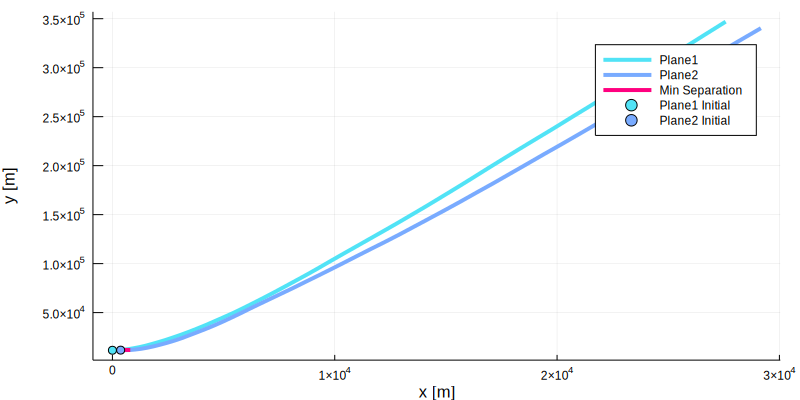

In [7]:
function AA120Q.sample_transition(s1::AircraftState, s2::AircraftState, model::DemoEncounterModel, params::EncounterSimParams)
    
    v = rand(model.transition) # [du, dv]
    a1 = AircraftAction(v[:du2], v[:dv2])

    v = rand(model.transition) # [du, dv]
    a2 = AircraftAction(v[:du2], v[:dv2])
    
    (a1, a2)
end

traj = rand(model, DEFAULT_SIM_PARAMS)
plot_trajectory(traj, 1)

## Milestone Two: Running with TCAS

We will use a simple TCAS (Traffic Alert and Collision Avoidance System) model.

The output of the simple TCAS will be a resolution advisory. The advisory provides the pilot with information in order to fly or avoid to resolve an encounter. The climb rate must be between ±4400 feet per minute.

We would like you to now write your own simulation (Refer back to assignment three for reference on plotting):

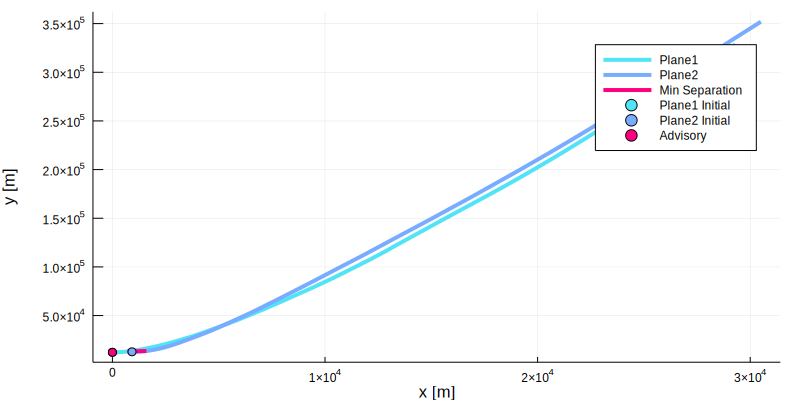

In [8]:
tcas = TCAS()
enc = rand(model, tcas, DEFAULT_SIM_PARAMS)
plot_encounter(enc)

### Generating a Dataset of Encounters

In [9]:
trajectories_noTCAS = generate_trajectories(1000, model, DEFAULT_SIM_PARAMS);

In [10]:
encounters_yesTCAS[1]

UndefVarError: UndefVarError: encounters_yesTCAS not defined

In [11]:
encounters_yesTCAS = generate_encounters(1000, model, tcas, DEFAULT_SIM_PARAMS);
trajectories_yesTCAS = [enc.traj for enc in encounters_yesTCAS];

### Pulling Miss Distance from Encounter

This will allow us to get the minimum separation of the two aircraft.

In [12]:
miss_distance = get_min_separation(trajectories_noTCAS[1])

595.3446207984645

### Pulling Distribution over Miss Distance from Encounters

This will plot the miss distance of randomly generated encounters.

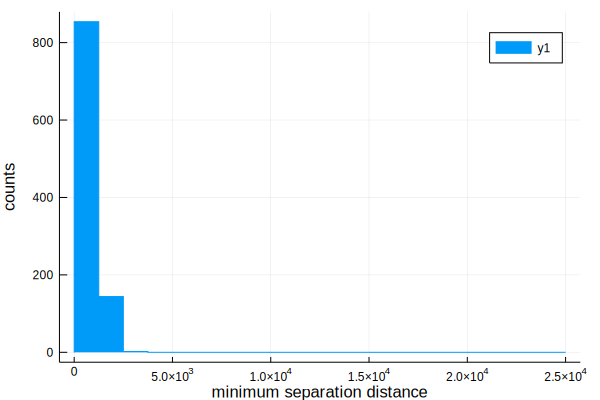

In [13]:
counts_sim = get_miss_distance_counts(trajectories_noTCAS)
plot_miss_distance_histogram(counts_sim)

### Comparing Simulated to Real Distribution

We can use the Kullback-Leibler Divergence to measure how much the simulated histogram diverges from the true distribution. Use this as a comparison to see how accurate system was compared the real thing.

In [14]:
function kullback_leibler_divergence(P, Q)
    probP = P ./ sum(P)
    probQ = Q ./ sum(Q)
    return sum(p * log(p/q) for (p,q) in zip(P,Q))
end

kullback_leibler_divergence (generic function with 1 method)

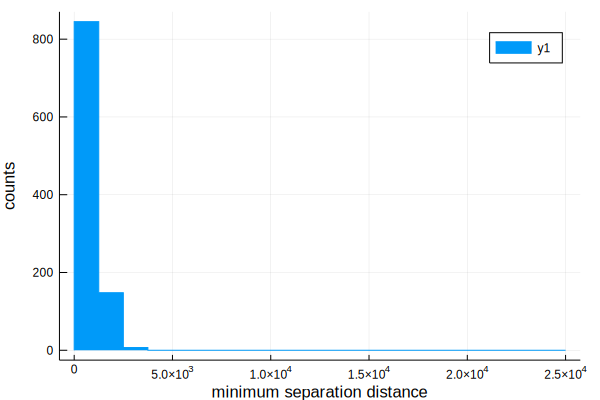

In [15]:
counts_sim = get_miss_distance_counts(trajectories_yesTCAS)
plot_miss_distance_histogram(counts_sim)

## Milestone Three: Safety Analysis

Run a Monte Carlo analysis using your encounter model, to estimate the probability that the encounter leads to a
near-midair collision (NMAC), which is defined as being a loss of 100ft vertical separation, and 500ft horizontal
separation. Estimate the collision frequency $P(col)$ using the NMAC rate obtained from a Monte Carlo estimate. 

$$P(collision \mid  model) = \frac{\text{n collisions}}{\text{n traces}}$$

You want to go through each trajectory and find the number of times that an NMAC occurs in each trajectory then divide by the number of trajectories to determine the probability of a collision given the model.

In [16]:
function has_NMAC(traj::Trajectory)
    # STUDENT CODE START
    # STUDENT CODE END
end

has_NMAC (generic function with 1 method)

In [17]:
function prob_of_collision(trajectories::Vector{Trajectory})
    # STUDENT CODE START
    # STUDENT CODE END 
end

prob_of_collision(trajectories_yesTCAS)

0.61

Students will be competing to see who's collision frequency estimate comes closest to the real world value. Winner's prize will be determined at the time of the competition.